In [7]:
import pandas as pd
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf


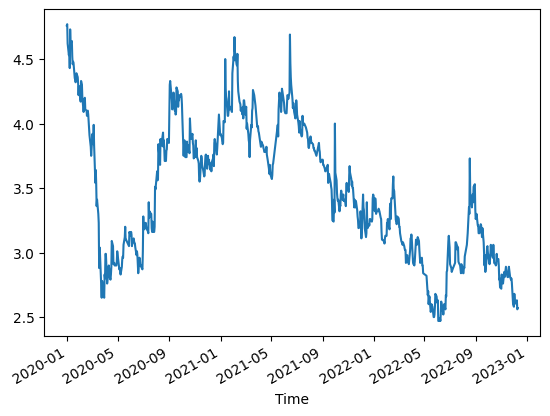

In [2]:
code = 'KEL'
filename = lambda x: f'stockdata/{x}.csv'
read = filename(code)

df = pd.read_csv(read,delimiter='\t',header=None)
df.columns = ['Time','Open','High','Low','Close','Volume']
df['Time'] = pd.to_datetime(df['Time'],infer_datetime_format=True)
df.set_index('Time',inplace=True)
df['Close'].plot()
plt.show()

In [3]:
df_stationarityTest = adfuller(df['Close'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  0.1353909232601498


In [4]:
len(df['Close'])

731

/home/daniyal/working/envs/timeseries/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


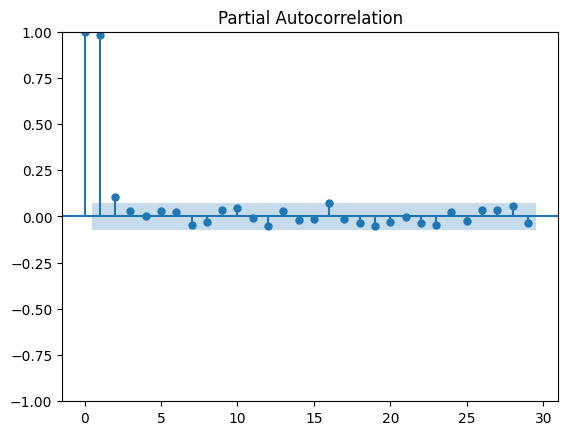

In [5]:
pacf = plot_pacf(df['Close'])

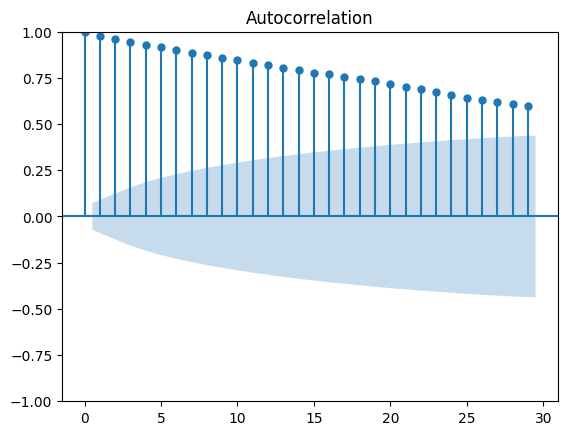

In [8]:
acf = plot_acf(df['Close'])